In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../../dmae/src/')
# from diffusion import DiffusionModel
# from evaluate import get_results
from omegaconf import OmegaConf
# from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model2 import Autoencoder, Preprocessor, Discriminator
import magic
import torch
import pathlib
import copy
from procrustes import Procrustes
import pickle
import graphtools
import scanpy as sc
from plotly3d.plot import scatter
from tqdm import tqdm

In [2]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

In [3]:
wandb.login()
api = wandb.Api()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [4]:
folder_path = '/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/src/wandb/'
entity = "xingzhis"
project = "dmae"
run_id = 'hdco3l9p'
# run_id = '2ycyrp8z'
# run_id = 'txickx2m'
# run_id = 'kcuupvd2'
# run_id = 'c7io5ycp'


In [5]:
run = api.run(f"{entity}/{project}/{run_id}")
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
model = Autoencoder.load_from_checkpoint(ckpt_path)
data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    model.eval()
    x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
    # x = torch.tensor(X, dtype=torch.float32, device=model.device)
    z = model.encoder(x).cpu().numpy()
    xh = model.decoder(torch.tensor(z)).cpu().numpy()

proc = Procrustes()
p1, z1, di = proc.fit_transform(data['phate'], z)

adata.obsm['X_gaga'] = z1
adata.obsm['X_pca_recon'] = xh

Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/src/wandb/run-20240907_173132-hdco3l9p/files/epoch=24-step=60000.ckpt`
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.


In [6]:
z_phate = proc.inverse_transform(data['phate'])
z_phate = torch.tensor(z_phate, dtype=torch.float32, device=model.device)
with torch.no_grad():
    xh_from_phate = model.decoder(z_phate).cpu().numpy()
adata.obsm['X_pca_recon_from_phate'] = xh_from_phate

In [7]:
scatter(z1, data['colors'], title=f'Latent space', s=3).show()
scatter(p1, data['colors'], title=f' Original phate', s=3).show()

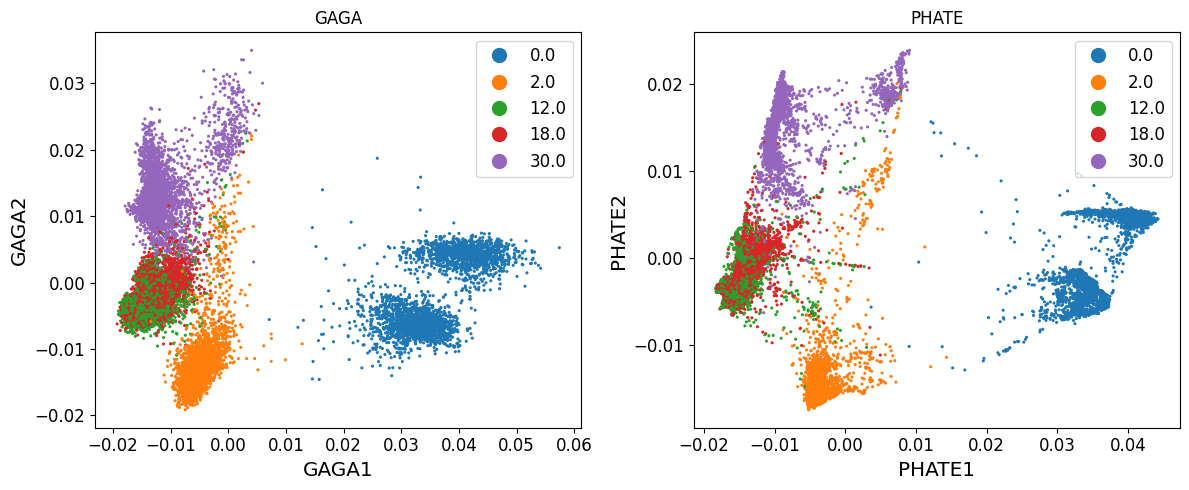

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

scprep.plot.scatter2d(adata.obsm['X_gaga'], c=adata.obs['day'], ticks=True, label_prefix="GAGA", ax=ax1)
ax1.set_title("GAGA")

scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['day'], ticks=True, label_prefix="PHATE", ax=ax2)
ax2.set_title("PHATE")

plt.tight_layout()
plt.show()

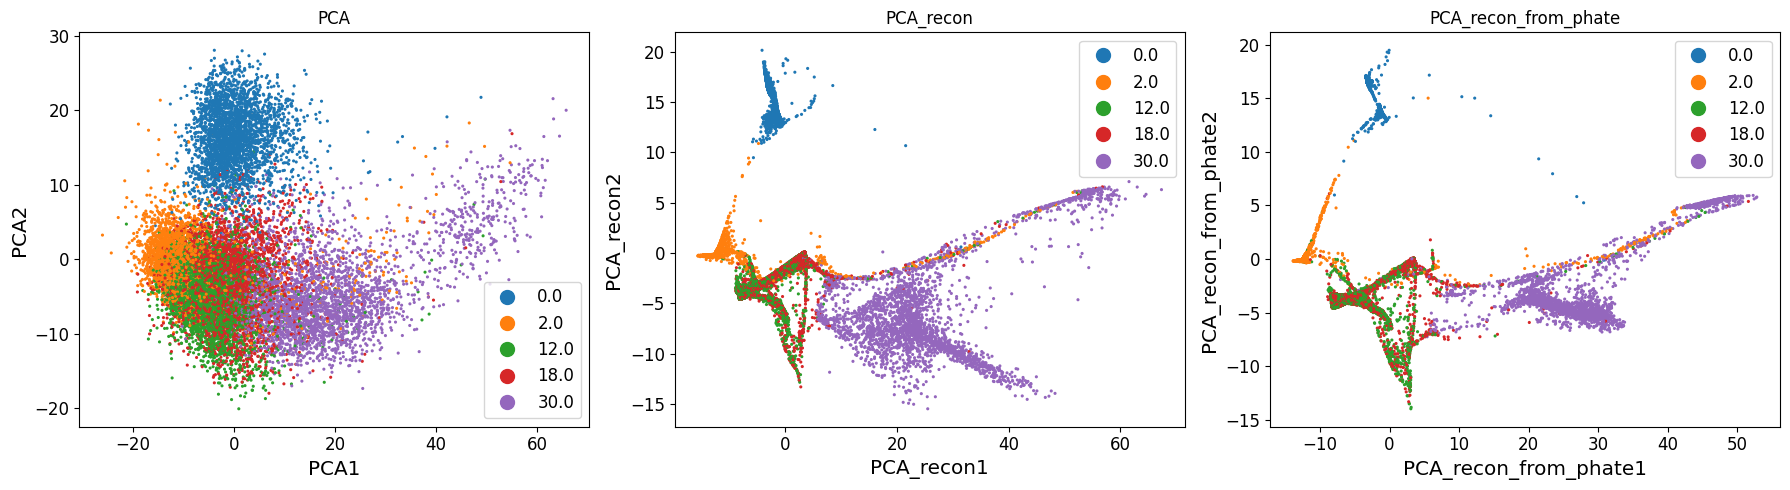

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

scprep.plot.scatter2d(adata.obsm['X_pca'], c=adata.obs['day'], ticks=True, label_prefix="PCA", ax=ax1)
ax1.set_title("PCA")

scprep.plot.scatter2d(adata.obsm['X_pca_recon'], c=adata.obs['day'], ticks=True, label_prefix="PCA_recon", ax=ax2)
ax2.set_title("PCA_recon")

scprep.plot.scatter2d(adata.obsm['X_pca_recon_from_phate'], c=adata.obs['day'], ticks=True, label_prefix="PCA_recon_from_phate", ax=ax3)
ax3.set_title("PCA_recon_from_phate")

plt.tight_layout()
plt.show()

In [10]:
np.abs(adata.obsm['X_pca_recon'] - adata.obsm['X_pca_recon_from_phate']).mean()

0.40175772

In [19]:
np.sqrt(np.square(adata.obsm['X_pca_recon'] - adata.obsm['X_pca_recon_from_phate']).mean())

1.0725757

In [20]:
np.sqrt(np.square(adata.obsm['X_pca'] - adata.obsm['X_pca_recon_from_phate']).mean())

2.7707715

In [11]:
np.abs(adata.obsm['X_pca_recon'] - adata.obsm['X_pca_recon_from_phate']).max()

33.656525

In [12]:
X_recon = (adata.obsm['X_pca_recon'] @ adata.varm['PCs'].T) + adata.X.toarray().mean(axis=0)
X_recon_from_phate = (adata.obsm['X_pca_recon_from_phate'] @ adata.varm['PCs'].T) + adata.X.toarray().mean(axis=0)

In [13]:
np.abs(X_recon - adata.X).mean()

0.1667193388370775

In [14]:
np.abs(X_recon_from_phate - adata.X).mean()

0.1664362388606959

In [15]:
np.square(X_recon_from_phate - adata.X).mean()

0.10507243133886641

In [16]:
np.abs(X_recon_from_phate - X_recon).mean()

0.013529125606151738

Since the reconstruction is the same as the decoding from phate, we can directly learn mioflow trajectories on the phate space -- this will reduce error.

In [17]:
with open(f'../data/4-procrustes.pkl', 'wb') as f:
    pickle.dump(proc, f)
adata.write(f"../data/4-gaga.h5ad")